In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_10_descriptive = get_prompt("descriptive", 10)
prompt_10_natural = get_prompt("natural", 10)

prompt_10_descriptive, prompt_10_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. 9. Compute the RMSD of the 400K simulation. 10. Compute the radius of gyration over time for the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute RMSD and radius of gyration of both simulations. Compute SASA for the 300K simulation.')

In [3]:
llm_model = "claude-3-5-sonnet-20240620"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_10_descriptive)

Thought: To complete all these tasks, I'll need to use multiple tools in sequence. Let's start with downloading the PDB file for 1LYZ.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we've successfully downloaded the PDB file for 1LYZ. Now, let's move on to the next task, which is to report the secondary structure assignments of the downloaded PDB structure.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_200014",
        "top_file": "1LYZ_200014",
        "target_frames": "first"
    }
}
```Thought: We've obtained the secondary structure assignments for 1LYZ. Now, let's find any known binding or active sites for this protein.

Action:
```
{
    "action": "GetUniprotID",
    "action_input": "1LYZ"
}
```Thought: Now that we have the UniProt ID for 1LYZ, let's use it to find the known binding or active sites.

Action:
```
{
    "action": "GetAllKnownSites",
   

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [5]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_200014: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_200014
 rec0_200017: dssp values for trajectory with id: 1LYZ_200014
 1LYZ_200035: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_200040: Initial positions for simulation sim0_200040
 sim0_200040: Basic Simulation of Protein 1LYZ_200035
 rec0_200044: Simulation trajectory for protein 1LYZ_200035 and simulation sim0_200040
 rec1_200044: Simulation state log for protein 1LYZ_200035 and simulation sim0_200040
 rec2_200044: Simulation pdb frames for protein 1LYZ_200035 and simulation sim0_200040
 rmsd_200040: RMSD for 200040
 fig0_200608: RMSD plot for 200040
 rgy_rec0_200044: Radii of gyration per frame for rec0_200044
 fig0_200612: Plot of radii of gyration over time for rec0_200044
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_201509: Plot of SASA over time for 1LYZ
 top_si

In [6]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_200014"))

In [7]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_200014", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [8]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [10]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("top_sim0_200040")
top_path_1_1 = registry_1.get_mapped_path("rec0_200044")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

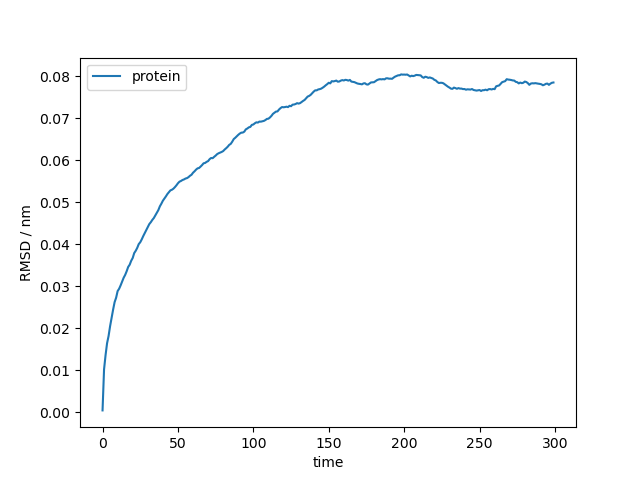

In [9]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_200608'))

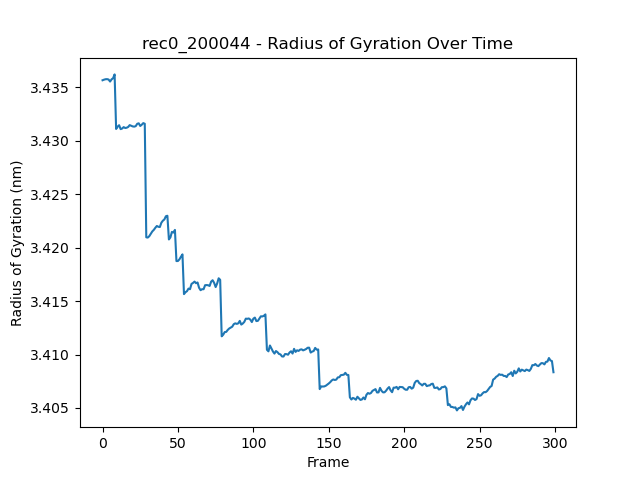

In [11]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_200612'))

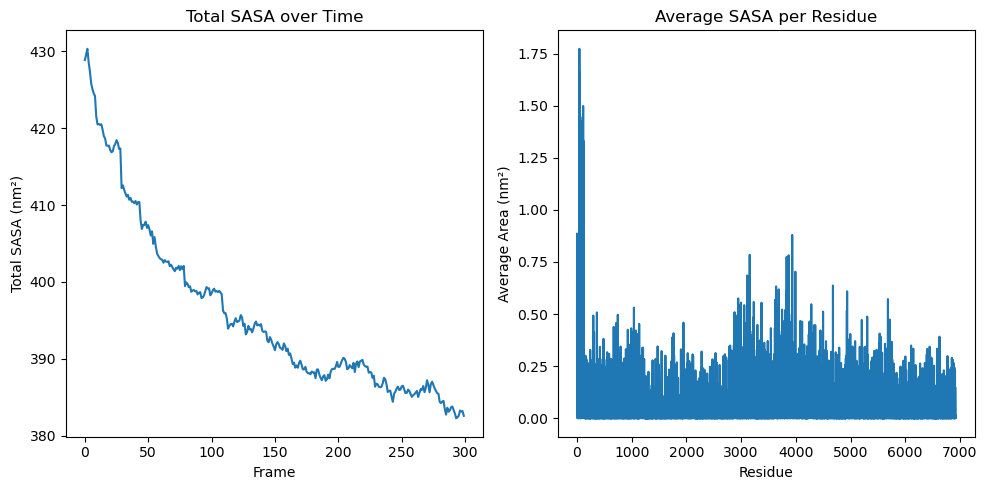

In [12]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_201509'))

In [14]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("rec0_201519")
top_path_1_2 = registry_1.get_mapped_path("top_sim0_201514")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

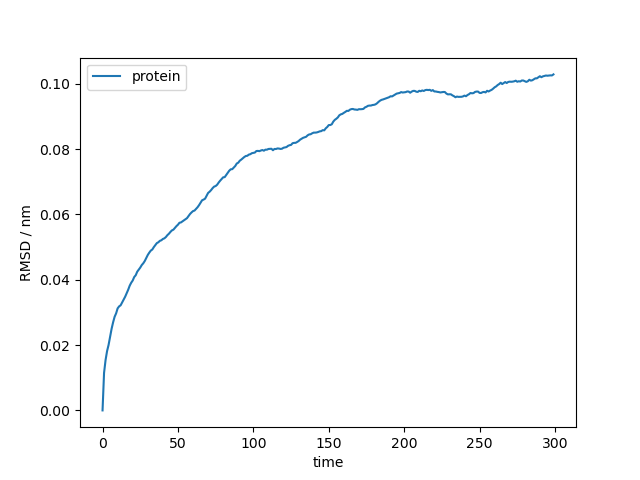

In [15]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_201956'))

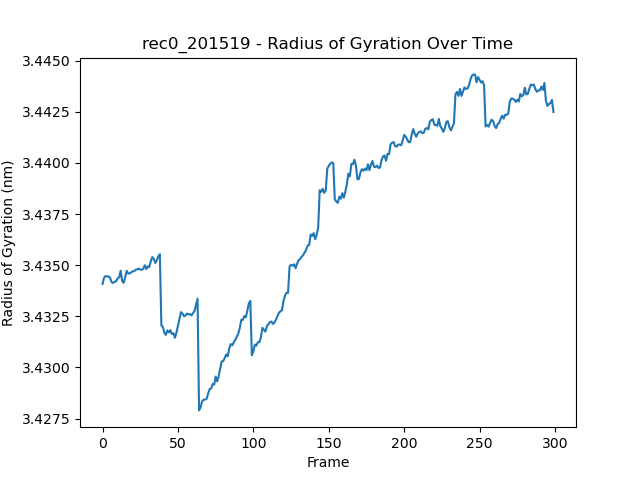

In [16]:
# make sure rgy plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_202000'))

In [17]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_10_natural)

Thought: To answer this question, I need to follow several steps. First, I'll download the PDB file for 1LYZ, then run simulations at 300K and 400K, analyze the secondary structure, find binding and active sites, compute RMSD, radius of gyration, and SASA. Let's start by downloading the PDB file.

Action:
```
{
    "action": "PDBFileDownloader",
    "action_input": "1LYZ"
}
```PDB file found with this ID: 1LYZ
Thought: Great, we have successfully downloaded the PDB file for 1LYZ. Now, let's analyze the secondary structure of the downloaded PDB structure and find any known binding or active sites.

Action:
```
{
    "action": "ComputeDSSP",
    "action_input": {
        "traj_file": "1LYZ_202416",
        "top_file": "1LYZ_202416",
        "target_frames": "first"
    }
}
```Thought: We've obtained the secondary structure information for 1LYZ. Now, let's find any known binding or active sites for this protein.

Action:
```
{
    "action": "GetUniprotID",
    "action_input": "1LYZ"
}
```

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [18]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_202416: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_202416
 rec0_202419: dssp values for trajectory with id: 1LYZ_202416
 1LYZ_202438: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_202446: Initial positions for simulation sim0_202446
 sim0_202446: Basic Simulation of Protein 1LYZ_202438
 rec0_202453: Simulation trajectory for protein 1LYZ_202438 and simulation sim0_202446
 rec1_202453: Simulation state log for protein 1LYZ_202438 and simulation sim0_202446
 rec2_202453: Simulation pdb frames for protein 1LYZ_202438 and simulation sim0_202446
 top_sim0_203027: Initial positions for simulation sim0_203027
 sim0_203027: Basic Simulation of Protein 1LYZ_202438
 rec0_203031: Simulation trajectory for protein 1LYZ_202438 and simulation sim0_203027
 rec1_203031: Simulation state log for protein 1LYZ_202438 and simulation sim0_20

In [19]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_202416"))

In [20]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_202416", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [21]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P17897")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [24]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("rec0_202453")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_202446")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

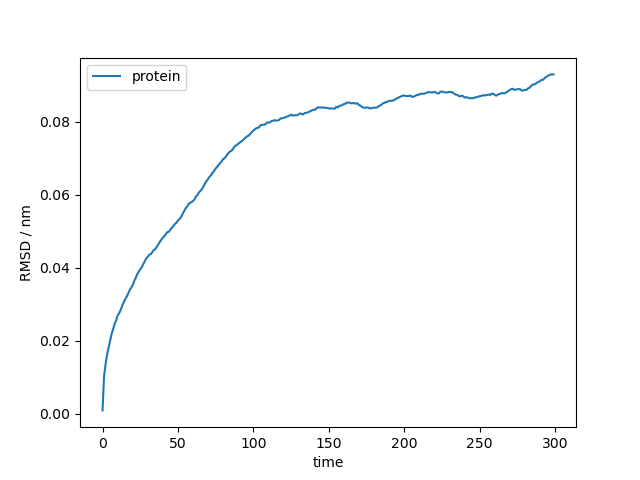

In [25]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_203447'))

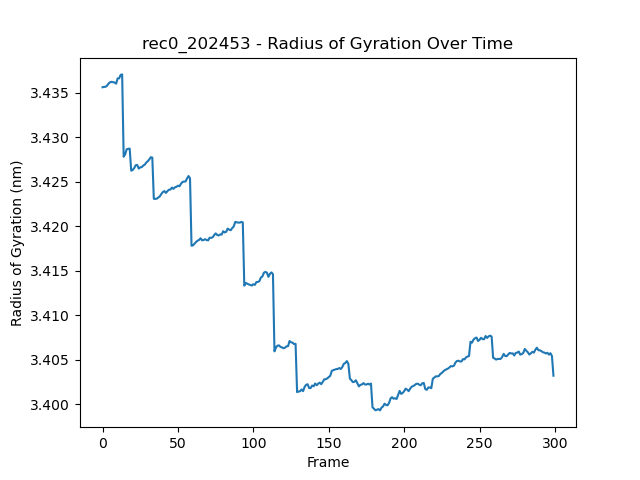

In [26]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_203455'))

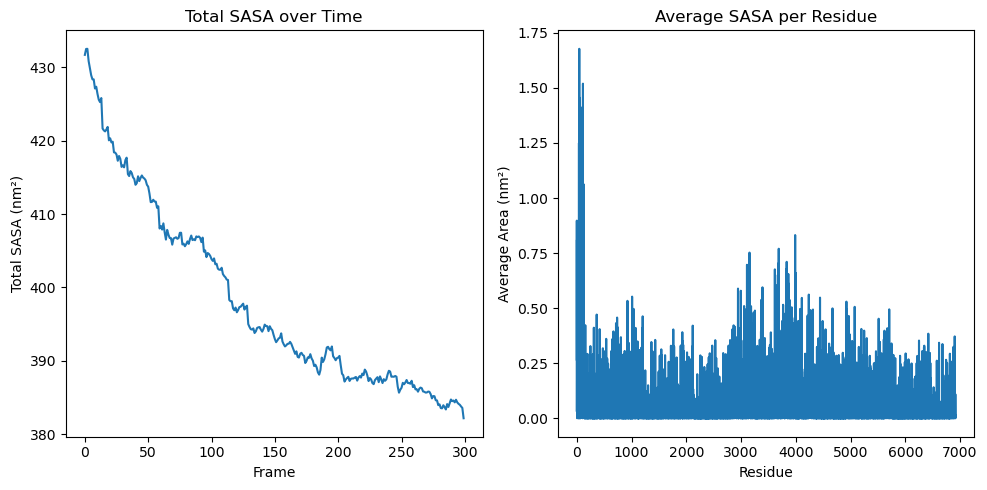

In [27]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_204443'))

In [28]:
# make sure trajectory and topology exist (sim1)
traj_path_2_2 = registry_2.get_mapped_path("rec0_203031")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_203027")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)

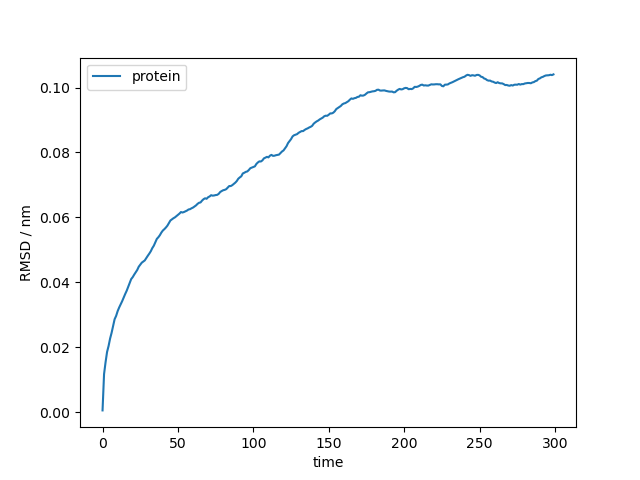

In [30]:
# make sure rmsd plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_203451'))

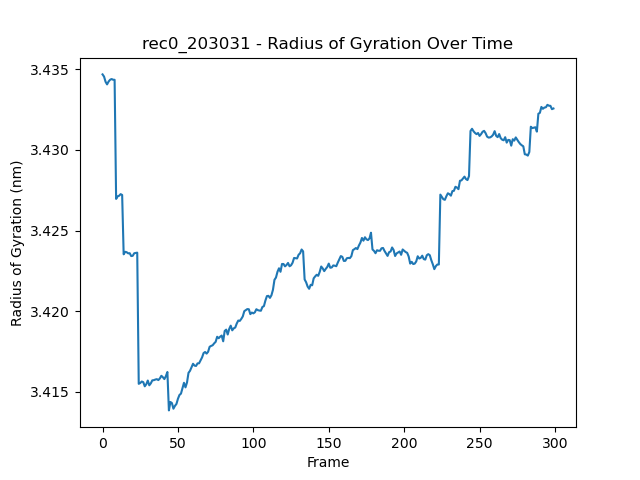

In [31]:
# make sure rgy plot was generated (sim2)
from IPython.display import Image
Image(filename=registry_2.get_mapped_path('fig0_203458'))